# Trabajo Práctico N° 3

El objetivo de este trabajo práctico es implementar modelos de regresión categórica que nos permita resolver problemas de clasificación.

Para ello utilizaremos un dataset "propio", es decir, fue seleccionado por los integrantes de nuestro grupo.

El dataset elegido fue una base de datos de estudios de Resonancia Magnética correspondiente a clientes de la empresa Canon Medical Systems Argentina.

Estos datos describen los estudios realizados por el resonador magnético indicando distintas características del mismo como:

- Fecha/Hora
- Duración
- Región Anatómica a la que corresponde
- Bobina de Radiofrecuencia Utilizada
- Tiempo de Repetición (RT)
- TIempo de Eco (TE)
- Campo de Visión (FOV)

La variable target elegida es la de **Región Anatómica**.

La idea es que según la región del cuerpo que se quiere estudiar (cabeza, tórax, muñeca, rodilla) van a variar distintos parámetros correspondientes al estudio como: tiempo de duración del mismo, tipo de bobina utilizado, campo de visión, plano de reconstrucción, tamaño de píxeles de la matriz de reconstrucción, etc.


## 0- Importación de Librerias 

In [1]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [2]:
#Establezco la dirección del archivo
file_location="datos_TP3.csv"

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)


### Visualizamos algunos registros del mismo. Desplegando todas las columnas

In [3]:
#Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

datos_crudos.sample(10)

,Study,No,Start,Scan ID,Mode,Scan Comment,Anatomy,PatientOrient,RcCoil,TxCoil,ContrastName,Plane,Sequence,Option,ScanMode,Time,TR,TE,FA,NS,ST,Gap,FOV,MTX,NAQ,BW,NoWrap,Options,Fltr,Gate,Coverages,Dynamic,SORS,FAT,MTC,Date,Site_ID,Site Name
90051,29853.8193,13,22:57,iAAS,(A),Shimming,Pelvis,H:S,BODY,WB,NaN,AX:AP,FE_AAS,NaN,(A),00:13,200,4.8/9.6,70,15,5.0,30.0,49.5,64,1.0,488,NaN,NaN,NL4,NaN,1,OFF,NaN,OFF,OFF,2022-09-09,8632,IRSA Jujuy
95635,30267.8193,24,08:02,COR SHIM (4.8,(A),COR SHIM (4.8 - 5.5),Chest,H:P,BRSTCX-1,WB,NaN,CO:RL,FE_AAS,NaN,(A),00:07,200,4.8/9.6,70,15,5.0,10.0,44.5,32,1.0,488,RO,NaN,NL4,NaN,1,OFF,NaN,OFF,OFF,2022-10-04,8632,IRSA Jujuy
60092,41208.8113,8,16:06,T2WI STIR,(A),SG T2WI STIR,TL-Spine,H:S,OHB-A,WB,NaN,SGo:COp,FSE2D+10,NaN,(A),02:51,3620,100,90/144,12,4.0,0.8,40.0 x 28.0,224 x 272,2.0,195,PE,NaN,GA54,NaN,1,OFF,NaN,OFF,OFF,2022-11-08,8630,Clinica Pequeña Familia
129333,41983.8380,9,20:50,MAP,(A),iMAP,Extremity,F:S,0x47410069,WB,NaN,AX:AP,FE_map,MAP,(A),00:25,185,4,20,23,6.0,4.5,26.2 x 25.3,64,1.0,488,RO,MAP,L1,NaN,1,OFF,NaN,OFF,OFF,2022-10-02,8633,Sanatorio Juncal
113917,40660.8380,6,14:19,Shimming,(AC),iAAS_TLSpine,TL-Spine,H:S,OSP-A,WB,NaN,AX:AP,FE_AAS,AAS,(AC),00:13,200,4.8/9.6,70,15,5.0,26.1,50.0,64,1.0,488,NaN,AAS,NL4,NaN,1,OFF,NaN,OFF,OFF,2022-08-08,8633,Sanatorio Juncal
53833,40618.8113,2,20:59,FLAIR,(A),AX FLAIR,Head,H:S,OHD-A,WB,NaN,AXo:RL,FSE2D+10,NaN,(A),03:00,10000,120,90/180,20,6.0,1.2,23.0,192 x 272,2.0,195,NaN,NaN,GA42,NaN,2,OFF,NaN,OFF,OFF,2022-10-11,8630,Clinica Pequeña Familia
130409,42069.8380,1,14:22,Loc 3Axis M/S(,(A),NaN,Pelvis,H:S,OSP-A,WB,NaN,Oth:AXp,FE_crt,SLT,(A),00:15,35,4,25,9,8.0,8.0,25.0,136 x 256,1.0,244,NaN,SLT,NL2,NaN,3,OFF,NaN,OFF,OFF,2022-10-05,8633,Sanatorio Juncal
37881,10733.8723,5,12:07,T2WI,(A),AX T2WI,TL-Spine,H:S,OSP-A,WB,NaN,Oth:Oth,FSE2D+10,:fcSS,(A),03:20,5400,120,90/160,20,5.0,0.5,20.0 x 18.0,256 x 272,2.0,244,PE/RO,:fcSS,GA54,NaN,1,OFF,NaN,OFF,OFF,2022-11-01,8629,Sanatorio Franchin
17068,35783.8268,2,16:39,T2 FASE,(AB),AX T2WI (BH) (FASE),Abdomen,H:S,BODY,WB,NaN,AX:AP,FASE2D+5,NaN,(AB),00:36,8032,60/+0(1),90/160,42,5.0,0.5,29.4 x 40.0,240 x 256,1.0,651,NaN,NaN,GA54,NaN,4,OFF,NaN,OFF,OFF,2022-11-10,8268,Clínica Modelo de Morón
86279,29562.8193,9,13:59,T2WI,(A),SG T2WI,TL-Spine,H:S,OSP-A,WB,NaN,Oth:Oth,FSE2D+9.5,NaN,(A),01:48,2286,123.5,90/160,14,3.5,1.0,39.0 x 20.0,288 x 320,2.0,244,PE,NaN,GA54,NaN,1,OFF,NaN,OFF,OFF,2022-08-25,8632,IRSA Jujuy


## Descripción de Columnas de Interés:

- PatientOrient: Orientación del paciente dentro del gantry.
- RcCoil: Bobina de Radiofrecuencia.  
- TxCoil: Bobina de Transmisión o Señal.
- Plane: Plano del estudio.
- Sequence: Tipo de secuencia del estudio.
- Time: Tiempo de duración en minutos de la secuencia.
- TR(Repetition Time): Tiempo entre secuencias de excitación.
- TE(Echo Time): Tiempo entre excitación de campo y señal de RM.
- FA (Flip Angle): Ángulo formado por el vector spin y el plano X-Y.
- NS (Number of Slices): Número de cortes axiales.
- ST (Slice Thickness): Grosor axial de la imagen adquiridad.
- Gap (Slice Gap): Distancia entre cortes axiales.
- FOV (Field of View): Campo de Visión, tamaño de porción anatómica que visualiza (cm x cm).
- MTX (Matrix): Matriz de reconstrucción de la imagen (pixel x pixel). Resolución espacial.
- NAQ (Number of Adquisitions): Número de adquisiciones en una secuencia dada.


# 2- Limpieza de Datos
### Verificamos la calidad de columnas en cuanto valores nulos

In [4]:
#Ordenando de mayor a menor por porcentaje de valores nulos en cada columna
datos_crudos.isna().sum().sort_values(ascending=False)/datos_crudos.shape[0]*100

SORS             99.656729
Gate             99.349739
ContrastName     96.485659
Options          82.476435
Option           82.476435
NoWrap           45.239208
ScanMode          8.969001
Mode              8.969001
Gap               5.034641
Scan Comment      3.875753
Scan ID           0.004186
NAQ               0.000000
BW                0.000000
Fltr              0.000000
Study             0.000000
Coverages         0.000000
MTX               0.000000
FAT               0.000000
MTC               0.000000
Date              0.000000
Site_ID           0.000000
Dynamic           0.000000
NS                0.000000
FOV               0.000000
ST                0.000000
No                0.000000
FA                0.000000
TE                0.000000
TR                0.000000
Time              0.000000
Sequence          0.000000
Plane             0.000000
TxCoil            0.000000
RcCoil            0.000000
PatientOrient     0.000000
Anatomy           0.000000
Start             0.000000
S

### Modificamos columnas que deberían ser numéricas, pero que tienen formato de objeto:
### Time, TE, FA, FOV y MTX

In [5]:
# Paso el campo Time con formato 00:00 a segundos
datos_crudos['Time'] = datos_crudos.Time.str.split(pat=':', expand=True)[0].astype(int)*60+\
                                datos_crudos.Time.str.split(pat=':', expand=True)[1].astype(int)

In [6]:
#Tomo el primer valor de Tiempo Eco
datos_crudos['TE'] = datos_crudos.TE.str.split(pat='/', expand=True)[0].astype(float)

In [7]:
#Primer Valor de Flip Angle
datos_crudos['FA'] = datos_crudos.FA.str.split(pat='/', expand=True)[0].astype(int)

In [8]:
#Separamos FOV en Ancho y Alto, Cuando se indica un solo valor: el FOV es cuadrado ( ancho = largo)
datos_crudos['FOV_1'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[0].astype(float)
datos_crudos['FOV_2'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[1].astype(float)

datos_crudos['FOV_2'] = datos_crudos.apply(lambda x: x['FOV_2'] if x['FOV_2'] > 0 else x['FOV_1'], axis=1)

In [9]:
#Analisis en Matriz de Reconstrucción es igual al del FOV 
datos_crudos['MTX_1'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[0].astype(int)
datos_crudos['MTX_2'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[1].astype(float)

datos_crudos['MTX_2'] = datos_crudos.apply(lambda x: x['MTX_2'] if x['MTX_2'] > 0 else x['MTX_1'], axis=1)
datos_crudos['MTX_2'] = datos_crudos['MTX_2'].astype(int)

### Removemos aquellas columnas que son redundantes y/o tiene altos valores de porcentajes nulos

In [10]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

### Ahora damos de la baja las filas donde haya valores nulos

In [11]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

### Verificamos las posibles categorías de la variable target "Región Anatómica"

In [12]:
datos.Anatomy.value_counts(normalize=True)*100

Head         25.284632
TL-Spine     19.461063
Extremity    18.760876
Abdomen      10.523525
Shoulder      7.211515
Pelvis        6.895809
C-Spine       6.854378
Ankle         2.365721
Hand          1.392088
Chest         1.210620
???           0.039774
Name: Anatomy, dtype: float64

In [13]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

## 3-Implementación de Modelos

### Definimos la matriz de features y el vector target

### No incluimos dentro la matriz de features algunas columnas que tienen una relación 1 a 1 con el vector target.

### Es el caso de las bobinas de Transmisión y de Radiofrecuencia, las mismas tienen una relación casi única con las partes anatómicas del cuerpo dónde son utilizadas. 

### También se omite el valor de tipo de secuencia que puede tener una relación muy estrecha con la región anatómica.

In [14]:
#Matriz de Features

X = datos[['PatientOrient','Plane','Time','TR','TE','FA','NS','ST','Gap','FOV_1','FOV_2','MTX_1','MTX_2','NAQ']]

#Vector Target
y = datos.Anatomy



In [15]:
#Separo las categóricas
categorical = X.select_dtypes("object").columns

### Separamos los datos en Train y Test

In [16]:
#Train y split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [17]:
X_train.shape

(96507, 14)

### Implementamos Dummies para las variables categóricas

In [18]:
from sklearn.preprocessing import OneHotEncoder 

def dummies_categoricas(categorias, dataframe1, dataframe2):    
        dataframe1_cat = dataframe1[categorias]
        dataframe2_cat = dataframe2[categorias]
        
        onehot = OneHotEncoder(drop = "first", handle_unknown='ignore')        
        X_enc_fit= onehot.fit_transform(dataframe1_cat).toarray()
        X_enc_trans= onehot.transform(dataframe2_cat).toarray()        
        
        enc_data_fit = pd.DataFrame(X_enc_fit, columns = onehot.get_feature_names_out())
        enc_data_trans = pd.DataFrame(X_enc_trans, columns = onehot.get_feature_names_out())
        
        dataframe1 = pd.concat([dataframe1.drop(columns=categorias).reset_index(drop=True), enc_data_fit], axis=1)
        dataframe2 = pd.concat([dataframe2.drop(columns=categorias).reset_index(drop=True), enc_data_trans], axis=1)
        
        return dataframe1, dataframe2 

In [19]:
X_train, X_test = dummies_categoricas(categorical, X_train, X_test)

In [20]:
#Nueva forma con variables categóricas
X_train.shape

(96507, 48)

In [21]:
X_train.head(5)

,Time,TR,TE,FA,NS,ST,Gap,FOV_1,FOV_2,MTX_1,MTX_2,NAQ,PatientOrient_F:S,PatientOrient_H:P,PatientOrient_H:R,PatientOrient_H:S,Plane_AX:AXp,Plane_AX:RL,Plane_AXo:AP,Plane_AXo:AXp,Plane_AXo:COp,Plane_AXo:Oth,Plane_AXo:RL,Plane_AXo:SGp,Plane_CO:COp,Plane_CO:HF,Plane_CO:RL,Plane_COo:AXp,Plane_COo:COp,Plane_COo:HF,Plane_COo:Oth,Plane_COo:RL,Plane_COo:SGp,Plane_Oth:AP,Plane_Oth:AXp,Plane_Oth:COp,Plane_Oth:Oth,Plane_Oth:RL,Plane_Oth:SGp,Plane_SG:AP,Plane_SG:HF,Plane_SG:SGp,Plane_SGo:AP,Plane_SGo:AXp,Plane_SGo:COp,Plane_SGo:HF,Plane_SGo:Oth,Plane_SGo:SGp
0,24,180,4.0,20,20,6.0,14.3,40.0,50.0,64,64,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69,4057,100.0,90,20,6.0,1.2,22.1,22.3,320,352,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,147,2921,18.0,90,24,3.0,0.6,20.0,20.0,192,256,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,220,4295,80.0,90,15,3.0,0.3,25.0,25.0,192,256,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,226,2168,24.0,90,24,3.8,0.8,18.0,18.0,256,320,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Escalamos


In [22]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler= scaler.transform(X_test)

### Definimos una función que evalue los modelos aplicando distintas métricas:

In [27]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

    # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = round(sensibilidad,2)

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = round(accuracy,2)

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = round(precision,2)

    # Calcular F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    resultados['F1 Score'] = round(f1_score,2)

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title(f'Matrix de Confusion {model}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin[model]= resultado_df 
    return resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})

## 3.1 - Regresión Logística

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, random_state=1)

lr.fit(X_train_scaler, y_train) 

ypred_lr_train = lr.predict(X_train_scaler)
ypred_lr_test = lr.predict(X_test_scaler)


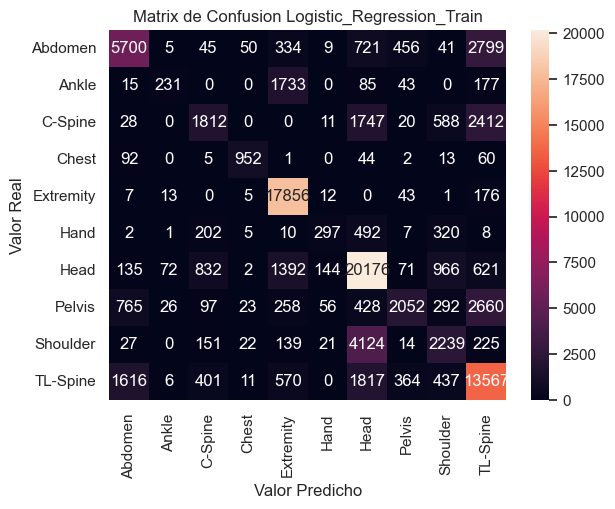

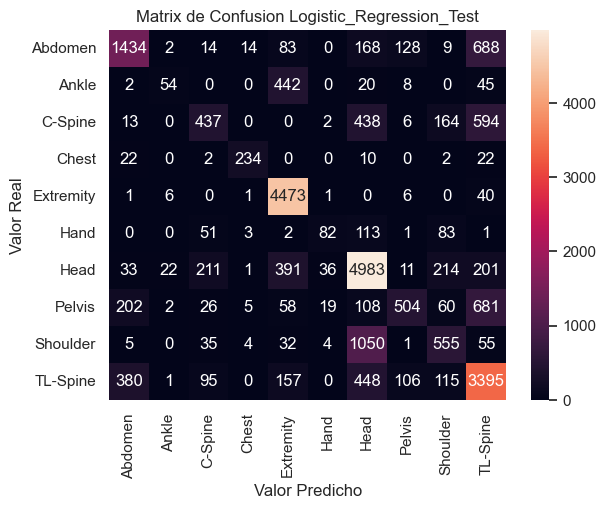

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.51,0.67,0.65,0.54
1,Logistic_Regression_Test,0.51,0.67,0.65,0.54


In [29]:
evaluacion(y_train, ypred_lr_train, model="Logistic_Regression_Train")


evaluacion(y_test, ypred_lr_test, model="Logistic_Regression_Test")


## 3.2 - Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_scaler, y_train)


ypred_gnb_train = gnb.predict(X_train_scaler)


ypred_gnb_test = gnb.predict(X_test_scaler)

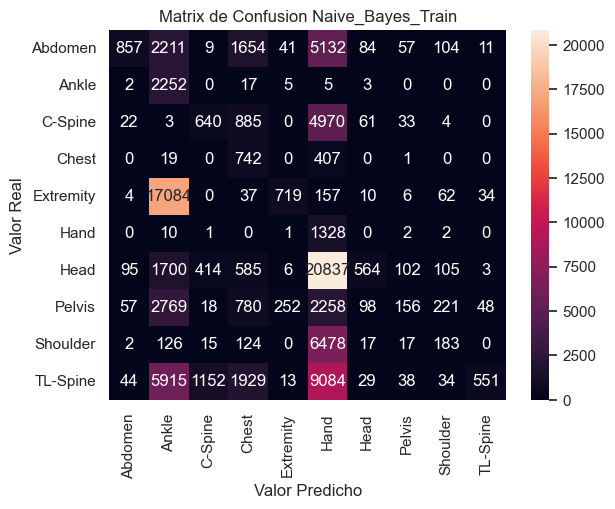

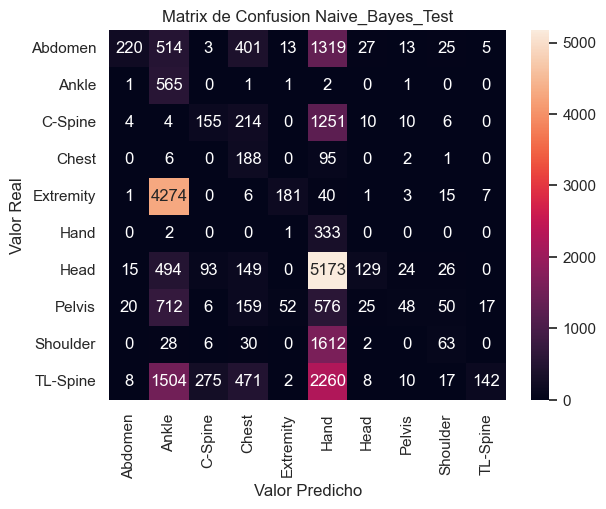

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.51,0.67,0.65,0.54
1,Logistic_Regression_Test,0.51,0.67,0.65,0.54
2,Naive_Bayes_Train,0.29,0.08,0.41,0.09
3,Naive_Bayes_Test,0.30,0.08,0.43,0.10


In [31]:

evaluacion(y_train, ypred_gnb_train, model="Naive_Bayes_Train")


evaluacion(y_test, ypred_gnb_test, model="Naive_Bayes_Test")

## 3.3 -KNN


In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Hyperparametros
parameters_knn = {"n_neighbors" : list(range(1, 15))}

clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1)
                   

# Fit el modelo ya seleccionado
clf_knn.fit(X_train_scaler, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             verbose=1)

In [33]:
print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_knn.best_params_, clf_knn.best_score_))

Los mejores parametros fueron {'n_neighbors': 5} con un score de 0.92


In [34]:
ypred_knn_train = clf_knn.predict(X_train_scaler)
ypred_knn_test = clf_knn.predict(X_test_scaler)

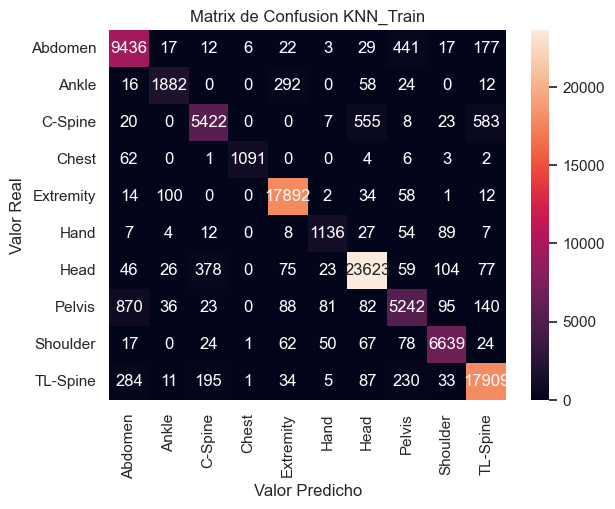

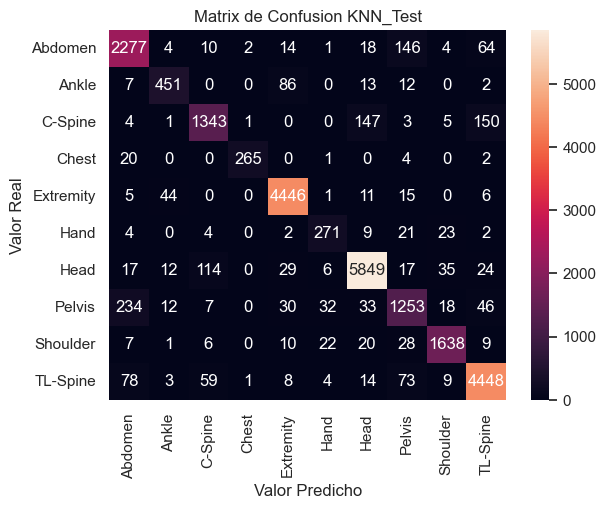

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.51,0.67,0.65,0.54
1,Logistic_Regression_Test,0.51,0.67,0.65,0.54
2,Naive_Bayes_Train,0.29,0.08,0.41,0.09
3,Naive_Bayes_Test,0.30,0.08,0.43,0.10
4,KNN_Train,0.90,0.94,0.92,0.91
5,KNN_Test,0.88,0.92,0.90,0.89


In [35]:

evaluacion(y_train, ypred_knn_train, model="KNN_Train")


evaluacion(y_test, ypred_knn_test, model="KNN_Test")

## 3.4 - Visualizacion y Comparativa de Modelos


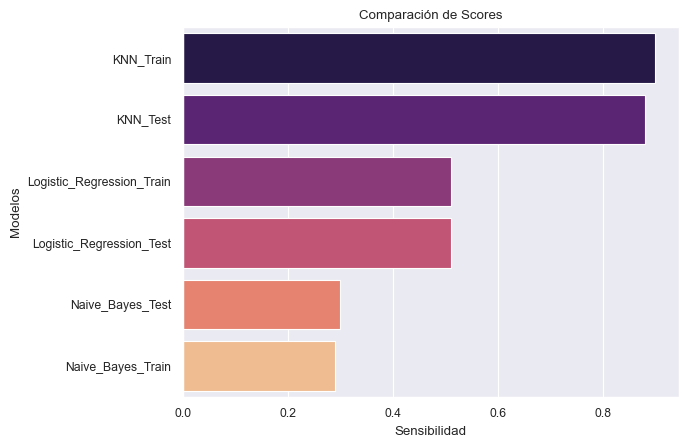

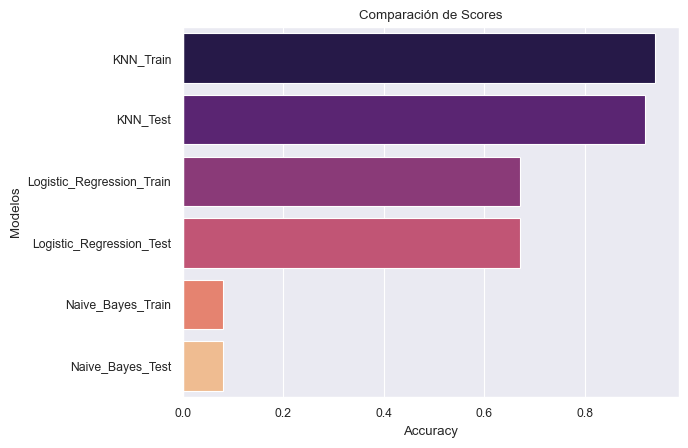

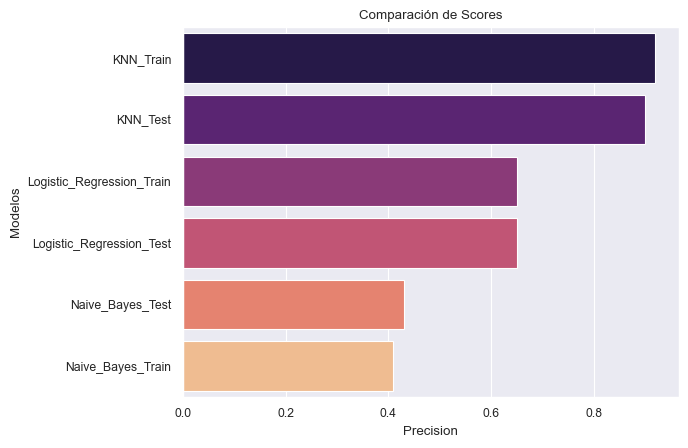

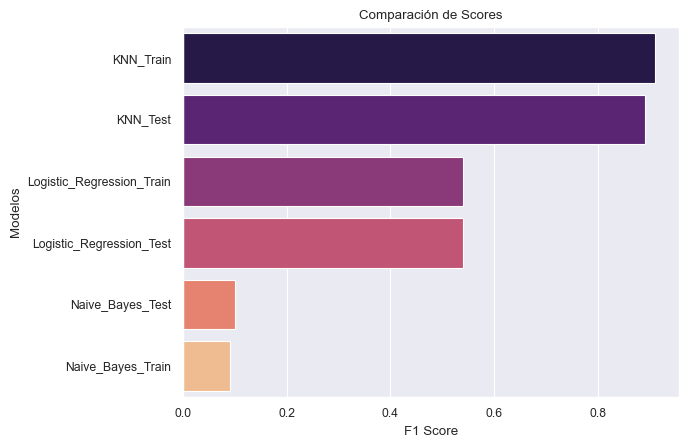

In [36]:
resultados_fin = resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})
scores_columns= ["Sensibilidad","Accuracy", "Precision", "F1 Score"]

for scores in scores_columns:
    sns.set_context('paper')
    ax = sns.barplot(x =resultados_fin[scores] ,y = "Modelos" ,data = resultados_fin.sort_values(by=scores, ascending=False), palette = 'magma')
    ax.set(xlabel=scores, ylabel="Modelos", title="Comparación de Scores")
    plt.show()